# Reading Particles + Application to Halo detection with Yt/hop and Halo mass function

In this notebook we will :
* upload a Dyablo Particle file
* interface with Yt
* create a Halo Catalog, using HOP
* plot the volumic distribution of halo masses (aka halo mass function HMF) and compare it to some reference

In [2]:
import numpy as np
import h5py
import yt
import numpy as np
import matplotlib.pyplot as plt
import sys, platform, os
from CosmoUtils import *
from yt.extensions.astro_analysis.halo_analysis import HaloCatalog
from tqdm import tqdm

In [3]:
plt.style.use('stylesheet.mplstyle')

In [4]:
import my_hmf_cmf_lib as mycmf

In [5]:
print(mycmf.TCMB)

2.7255


## Upload Particle file

In [6]:
# nb_iter, zsnap = ["0000000",26.1272]
# nb_iter, zsnap = ["0000250",2.47551]
nb_iter, zsnap = ["0002850",0.0]

filename = f"cosmo_particles_particles_iter{nb_iter}.h5"

fpart = h5py.File(f'datastageM2/{filename}', 'r')

positions = np.array(fpart['coordinates'])
print(np.shape(positions))

x=positions[:,0]
y=positions[:,1]
z=positions[:,2]
Npart=np.size(x)


# Uncomment if velocities are available in the Dyablo output
#vx = np.array(fpart['vx'])
#vy = np.array(fpart['vy'])
#vz = np.array(fpart['vz'])

(16777216, 3)


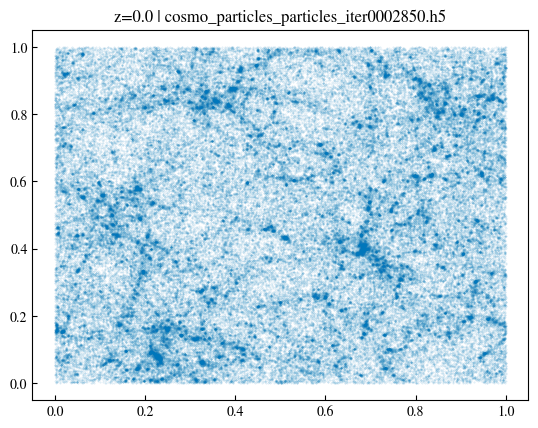

In [7]:
plt.figure()
plt.title(f"z={zsnap} | {filename}")
plt.scatter(x[::100],y[::100], alpha=0.15, s=0.15)
# plt.scatter(x[::10],y[::10], alpha=0.01, s=0.15)
# plt.scatter(x[::2],y[::2], alpha=0.01, s=0.03)
plt.show()

### Some run parameters

In [8]:
#grid size
# nx = 256
# ny = 256
# nz = 256

# grid_size = [nx,ny,nz]


In [9]:
L=164 #Mpc/h
H0org=67.00 # km/s/Mpc
om=0.3175 # total density parameter

# Computing the Particle Mass
H0=H0org*1e3/3.086e22
h=H0org/100.
rhoc=3*H0**2/(8*np.pi*6.67e-11) #kg/m^3
rho0 = rhoc * om
mpart=rho0*(L/h*3.086e22)**3/Npart #kg #either rhoc * om or rho0
print('particle mass [Solar Mass] = {:e}'.format(mpart/2e30))

particle mass [Solar Mass] = 3.440346e+10


In [10]:
grid_size = [L/h, L/h, L/h]

In [11]:
print(f"mean density : {rho0:.2e} kg/m^3")

mean density : 2.68e-27 kg/m^3


In [12]:
rho_MsunMpc3 = rho0 / 2e30 * 3.086e22**3 #Msun/Mpc^3
print(f"mean density : {rho_MsunMpc3:.2e} Msun/Mpc^3")

mean density : 3.94e+10 Msun/Mpc^3


## Interfacing with Yt

In [13]:
masses=np.ones(Npart) # dummy particle masses array as a set of unit masses
idx=np.arange(Npart) # monotonic indexes for particles

data = dict(
    particle_position_x=x,
    particle_position_y=y,
    particle_position_z=z,
    particle_velocity_x=x,#dummy with no vel
    particle_velocity_y=y,#dummy with no vel
    particle_velocity_z=z,#dummy with no vel
    particle_mass=masses,
    particle_index=idx
)
ds = yt.load_particles(data,length_unit=L*3.086e24,periodicity=(True,True,True),mass_unit=mpart*1e3)

yt : [INFO     ] 2025-03-24 12:28:23,711 Parameters: current_time              = 0.0
yt : [INFO     ] 2025-03-24 12:28:23,713 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-03-24 12:28:23,715 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-03-24 12:28:23,717 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-03-24 12:28:23,718 Parameters: cosmological_simulation   = 0


## Hop Launch

#### Catalog Creation using Hop via Yt

VERY LONG !

In [14]:
# hc = HaloCatalog(data_ds=ds, finder_method="hop",output_dir="./datastageM2/")

In [15]:
# hc.create() # launch in background

In [16]:
fhalo = h5py.File('datastageM2/ParticleData/ParticleData.0.h5', 'r') # upload Hop results

In [17]:
xh=np.array(fhalo['particle_position_x']) #HOP halo positions
yh=np.array(fhalo['particle_position_y']) #HOP halo positions
zh=np.array(fhalo['particle_position_z']) #HOP halo positions
mh=np.array(fhalo['particle_mass']) #HOP halo mass

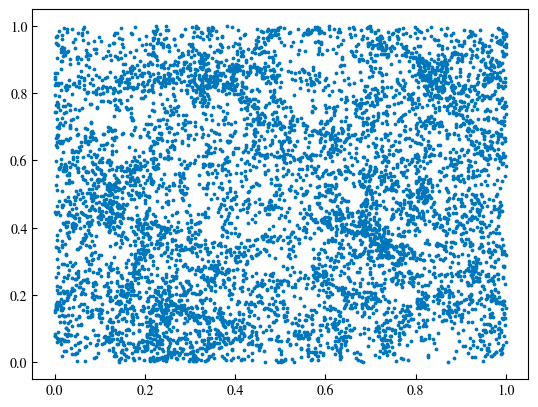

In [18]:
plt.figure()
#plt.scatter(x,y,alpha=0.05,s=0.5) # scatter plot of particle positions
plt.scatter(xh,yh,s=3.0) # scatter plot of halo positions

In [19]:
print(len(xh), "halos in the whole domain")

7084 halos in the whole domain


## Mass function

In [20]:
from hmf import MassFunction

In [21]:
## Mass distriubtion Fit/model from litterature 
# Note that we assume that Initial conditions parameters matches with the MassFunction parameters
hmf = MassFunction(z=zsnap,Mmin=8,hmf_model="ST")
dndm=hmf.dndm # differential halo mass distribution

/home/mesquita/.local/lib/python3.10/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [22]:
# hmf.parameter_values

In [23]:
pars,results,s8_fid = mycmf.compute_init_power_spectrum(zsnap, H0org, mycmf.TCMB, om, mycmf.ob, h, mycmf.ns, mycmf.As)

Note: redshifts have been re-sorted (earliest first)


In [24]:
M_list = np.logspace(8,15,1000) #Msun/h

In [25]:
#compute the power spectrum for a given redshift
kh, _, pk = mycmf.compute_matter_power_spectrum(zsnap, pars, s8_fid)

n_ST_list = [mycmf.hmfcalc(M_list[i], kh, pk, "ST") for i in range(len(M_list))]

Note: redshifts have been re-sorted (earliest first)


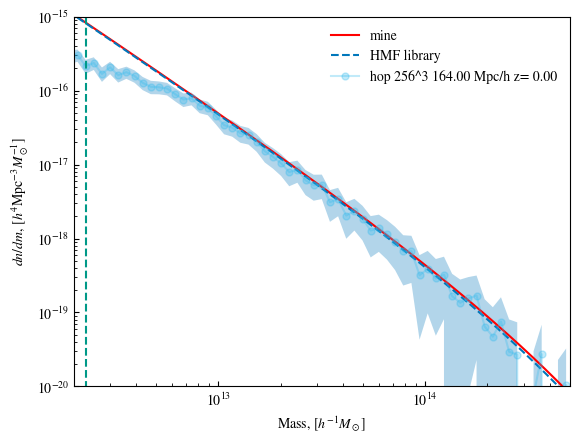

In [26]:
# Plot the reference HMF
plt.figure()
plt.plot(M_list, n_ST_list, color="red", label = "mine")
plt.plot(hmf.m,hmf.dndm,'--' , label="HMF library")
plt.yscale('log')
plt.xscale('log')

###### We compute the histogram of the halo mass for our simulation
bins_hmf=np.logspace(11,16,num=128)
bcen_hmf=0.5*(bins_hmf[1:]+bins_hmf[:-1])
db_hmf=bins_hmf[1:]-bins_hmf[:-1]
# Halo mass function using Hop mass estimate, note that masses must be given in Msol/h
# Note : hop mass is slightly underestimated compared to proper M200 calculation
myhmf,bmf=np.histogram(mh*h,bins=bins_hmf) #<<< msol/h

mydndm_hmf=myhmf/db_hmf/L**3
mydndm1_hmf=mydndm_hmf+3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion
mydndm2_hmf=mydndm_hmf-3*np.sqrt(myhmf)/db_hmf/L**3 #3 sigma dispersion


# Plot
plt.plot(bcen_hmf,mydndm_hmf,'-o',markersize=5,label='hop 256^3 {:5.2f} Mpc/h z={:5.2f}'.format(L,zsnap),alpha=0.3)
plt.fill_between(bcen_hmf,mydndm1_hmf,mydndm2_hmf,alpha=0.3)
plt.xlabel(r"Mass, $[h^{-1}M_\odot]$")
plt.ylabel(r"$dn/dm$, $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$");
plt.xlim([2e12,5e14])
plt.ylim([1e-20,1e-15])
plt.plot(np.ones(10)*100*mpart*h/2e30,np.linspace(np.min(hmf.dndm),np.max(hmf.dndm),10),'--')
plt.legend()

# Exploring the empirical CMF

In [27]:
def norm2dist(norm_val, grid_size):
    '''
    norm_val between 0 and 1
    dist in Mpc
    '''
    for i in range(len(grid_size)-1):
        if grid_size[i]!=grid_size[i+1]:
            print("The grid is does not have the same size in all directions.")
            return -1
    dist = norm_val * grid_size[0]
    return dist

def dist2norm(dist, grid_size):
    '''
    dist in Mpc
    norm_val between 0 and 1
    '''
    for i in range(len(grid_size)-1):
        if grid_size[i]!=grid_size[i+1]:
            print("The grid is does not have the same size in all directions.")
            return -1
    norm_val = dist / grid_size[0]
    return norm_val

In [28]:
x_mpc = norm2dist(x, grid_size)
y_mpc = norm2dist(y, grid_size)
z_mpc = norm2dist(z, grid_size)
part_pos_mpc = np.column_stack((x_mpc, y_mpc, z_mpc))

xh_mpc = norm2dist(xh, grid_size)
yh_mpc = norm2dist(yh, grid_size)
zh_mpc = norm2dist(zh, grid_size)
halo_pos_mpc = np.column_stack((xh_mpc, yh_mpc, zh_mpc))

In [29]:
def idx_of_part_in_shape(center_sphere, size, grid_size, pos_mpc, shape="sphere"):
    #size: Radius (for sphere) or half-width (for cube).
    cx, cy, cz = center_sphere
    x, y, z = pos_mpc[:,0], pos_mpc[:,1], pos_mpc[:,2]
    xsize, ysize, zsize = grid_size
    
    dx = np.minimum(abs(x - cx), xsize - abs(x - cx)) #either normal distance or substracting the grid_size 
    dy = np.minimum(abs(y - cy), ysize - abs(y - cy))
    dz = np.minimum(abs(z - cz), zsize - abs(z - cz))
    
    if shape == "sphere":
        d = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        w = np.where(d < size) 
    elif shape == "cube":
        inside_x = dx < size
        inside_y = dy < size
        inside_z = dz < size
        w = np.where(inside_x & inside_y & inside_z)  
    else :
        print("Choose 'sphere' or 'cube' in the shape arg.")
    return np.array(w[0])

Before using KDTree, we need to take into account the periodicity of the domain since it can't do that.

Let's center the domain, on our sphere of choice.

In [30]:
def shift_to_sphere_center(sphere_center, grid_size, points):
    '''
    points = [(x1,y1,z1), (x2,y2,z2), ...]
    '''
    nx, ny, nz = grid_size
    x, y, z = sphere_center
    
    xc, yc, zc = nx / 2, ny / 2, nz / 2 #domain center
    dx, dy, dz = xc - x, yc - y, zc - z
    
    shifted_points = np.array([( (X + dx) % nx, (Y + dy) % ny, (Z + dz) % nz ) for X, Y, Z in points])
    
    return shifted_points

Making a more general function for later (one method might be faster than the other)

In [31]:
from scipy.spatial import KDTree

def idx_halos(center_sphere, radius_sphere, grid_size, halo_pos_mpc, method="Manual", shape="sphere"):
    if method == "KDTree":
        #computing the shifted postion such tha tthe sphere is at the center
        shifted_halos_to_sphere = shift_to_sphere_center(center_sphere, grid_size, halo_pos_mpc)
        
        #creating instances of KDTrees to use their methods
        tree_halo = KDTree(shifted_halos_to_sphere)
        
        nx,ny,nz = grid_size
        shifted_center_sphere = [nx / 2, ny / 2, nz / 2] #new center in the center of the box
        
        #finding the number of halos in the sphere using query_ball_point 
        idx_of_halos_in_sphere_kdtree = np.array(tree_halo.query_ball_point(shifted_center_sphere,radius_sphere))
        
        return idx_of_halos_in_sphere_kdtree
    elif method == "Manual":
        #idx of halos and particles in the sphere respectively
        w_halos = idx_of_part_in_shape(center_sphere, radius_sphere, grid_size, halo_pos_mpc, shape=shape)
        
        return w_halos
    else : 
        print(r"Method not recognized ! Choose between 'KDTree' and 'Manual'.")
        return -1

In [32]:
def sphere_density(Rsphere, nb_part, mpart):
    '''
    Rsphere in Mpc
    rho_sphere in Msun/Mpc^3
    '''
    Msphere = mpart / 2e30 * nb_part #in Msun
    Vsphere = 4/3*np.pi*Rsphere**3 #in Mpc**3
    rho_sphere = Msphere / Vsphere #Msun/Mpc**3
    return rho_sphere

def density_in_shape(center_sphere, size_shape, grid_size, part_pos_mpc, mpart, shape="sphere"):
    w_part = idx_of_part_in_shape(center_sphere, size_shape, grid_size, part_pos_mpc, shape=shape)
    nb_part_in_shape = len(w_part)
    if shape == "sphere":
        rho_shape = sphere_density(size_shape, nb_part_in_shape, mpart)
    elif shape == "cube":
        rho_shape = mpart/2e30 * nb_part_in_shape / (2*size_shape)**3
    else :
        print("Choose 'sphere' or 'cube' in the shape arg.")
    return rho_shape

In [33]:
center_sphere = np.array([181,155,205])
# radius_sphere = nx*np.sqrt(3)/2 #Mpc # WHOLE DOMAIN
radius_sphere = 18.39 # Mpc
volume_sphere = 4/3*np.pi*radius_sphere**3

[1/2] Computing the number of halos inside a sphere of center [229.  53. 183.] and radius 35.00...
Found 197 halos inside the sphere of center [229.  53. 183.] and radius 35.00 of overdensity 0.53.

[2/2] Computing the number of halos inside a sphere of center [148. 196. 168.] and radius 35.00...
Found 81 halos inside the sphere of center [148. 196. 168.] and radius 35.00 of overdensity -0.08.

Average of non-linear density : 0.41529292158552
Average of linear density : 0.22716023767062926


/tmp/ipykernel_3660069/2637626756.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


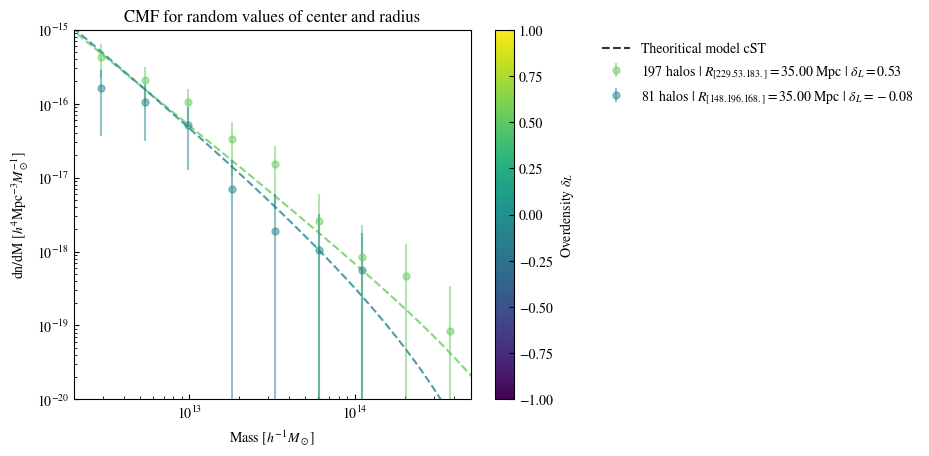

In [34]:
#CMF for random values of center and radius
import matplotlib.cm as cm

# Ntest = 2
Ntest = 2
min_radius = 10

delta_NL_list = []
delta_L_list = []

plt.figure()

# cmap = cm.turbo_r
cmap = cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1)

for i in range(Ntest):
    rand_cx = np.random.rand() * (L/h) #nx
    rand_cy = np.random.rand() * (L/h) #ny
    rand_cz = np.random.rand() * (L/h) #nz
    rand_center = [rand_cx, rand_cy, rand_cz]
    
    # rand_radius = min_radius + np.random.rand() * 30 #Mpc
    
    rand_radius = 35 #Mpc
        
    # if i==0:
    #     rand_radius = L/h/2
    
    print(f"[{i+1}/{Ntest}] Computing the number of halos inside a sphere of center {np.round(rand_center,0)} and radius {rand_radius:.2f}...")
    current_halos = idx_halos(rand_center, rand_radius, grid_size, halo_pos_mpc, "Manual")
    
    current_density = density_in_shape(rand_center, rand_radius, grid_size, part_pos_mpc , mpart)
        
    mh_in_sph = mh[current_halos]

    halos_found = len(mh_in_sph)
    
    if halos_found == 0 :
        print(f"No halos found inside the sphere of center {np.round(rand_center,0)} and radius {rand_radius:.2f} of density {current_density} Msun/Mpc^3.\n")
    else :
        lightest_halo = np.min(mh_in_sph)
        heaviest_halo = np.max(mh_in_sph)
        
        # current_bins=np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo),num=int(np.sqrt(halos_found)))
        current_bins=np.logspace(11, 16,num=20)

        current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
        current_db=current_bins[1:]-current_bins[:-1]

        current_cmf,current_bin_edges = np.histogram(mh_in_sph*h,bins=current_bins) 
        
        
        Vsphere = 4/3*np.pi*(rand_radius*h)**3
        current_dndm=current_cmf/current_db/Vsphere
        
        #error bars
        current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/Vsphere #3 sigma dispersion
        current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/Vsphere #3 sigma dispersion
        dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
        
        delta_NL = (current_density - rho_MsunMpc3)  / rho_MsunMpc3 #non-linear
        delta_NL_list.append(delta_NL)
        delta_L = mycmf.compute_delta_linear(delta_NL) #delta_L = delta_0
        delta_L_list.append(delta_L)
        
        print(f"Found {halos_found} halos inside the sphere of center {np.round(rand_center,0)} and radius {rand_radius:.2f} of overdensity {delta_L:.2f}.\n")

        ### MY CMF COMPUTATION
        cST_list = [mycmf.cmfcalc(M_list[i], kh, pk, rand_radius*h, delta_L, "cST") for i in range(len(M_list))]
        EPS_list = [mycmf.cmfcalc(M_list[i], kh, pk, rand_radius*h, delta_L, "EPS") for i in range(len(M_list))]
        ###
         
        color = cmap(norm(delta_L))
        if 1 : #delta_L > 0.4 : 
            # plt.loglog(M_list, EPS_list, '-' ,color=color, alpha=0.8)
            plt.loglog(M_list, cST_list, '--' ,color=color, alpha=0.8)
            # plt.loglog(current_bcen, current_dndm, '-o', markersize=5, alpha=0.5, color=color,
            # label=f"{halos_found} halos | $R_{{{np.round(rand_center,0)}}}={rand_radius:.2f}$ Mpc | $\delta_L={delta_L:.2f}$")
            plt.errorbar(current_bcen, current_dndm,
                         yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                         fmt='o', markersize=5, alpha=0.5, color=color,
                         label=f"{halos_found} halos | $R_{{{np.round(rand_center,0)}}}={rand_radius:.2f}$ Mpc | $\delta_L={delta_L:.2f}$")

print(f"Average of non-linear density : {np.mean(delta_NL_list)}")
print(f"Average of linear density : {np.mean(delta_L_list)}")

# plt.loglog([], [], '-', label='Theoritical model EPS', color='k', alpha=0.8)
plt.loglog([], [], '--', label='Theoritical model cST', color='k', alpha=0.8)
# plt.plot(bcen_hmf,mydndm_hmf,'-o',markersize=5, color = "k", label=f"HMF,  $\\rho_0$ = {rho_MsunMpc3:.2e} $Msun/Mpc^{3}$",alpha=0.4)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label(f'Overdensity $\delta_L$')

plt.xlabel(r"Mass $[h^{-1}M_\odot]$")
plt.ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
plt.xlim([2e12,5e14])
plt.ylim([1e-20,1e-15])

# plt.xlim([2e12,1e15])
# plt.ylim([1e-21,1e-15])
plt.title(f"CMF for random values of center and radius")
plt.legend(bbox_to_anchor=(1.3, 1),loc='upper left')
plt.show()

In [35]:
def paving_domain(N, grid_size):
    nx, ny, nz = grid_size
    dx, dy, dz = nx / N, ny / N, nz / N  # diameter  in each coordinate
    radius = min(dx, dy, dz) / 2  # min to not have spheres that overlap

    i, j, k = np.meshgrid(np.arange(0,N,1), np.arange(0,N,1), np.arange(0,N,1), indexing='ij')

    centers = np.stack(((i+0.5) * dx, (j+0.5) * dy, (k+0.5) * dz), axis=-1) #+0.5 at each i j k?

    centers = np.reshape(centers, (-1,3))
    
    return centers, radius

In [36]:
class subregion:
    def __init__(self, center, radius, shape="sphere"):
        self.center = np.array(center)
        self.radius = radius #radius for sphere / half_width for cube
        self.shape = shape #sphere or cube
        self.density = None #Msun/Mpc^3
        self.delta_NL = None
        self.delta_L = None # = delta0
        self.halo_indices = []
        self.num_halos = 0
        self.cmf_emp = None
        self.err_emp = None
        self.bcen_emp = None
        self.cmf_th_cST = None
        self.cmf_th_EPS = None
        self.bins_emp = None
    
    def get_idx_particles_inside(self, part_pos_mpc):
        cx, cy, cz = self.center
        if self.shape == "cube":
            w = np.where((part_pos_mpc[:, 0] >= cx - self.radius) & (part_pos_mpc[:, 0] < cx + self.radius) &
                         (part_pos_mpc[:, 1] >= cy - self.radius) & (part_pos_mpc[:, 1] < cy + self.radius) &
                         (part_pos_mpc[:, 2] >= cz - self.radius) & (part_pos_mpc[:, 2] < cz + self.radius))[0]
        elif self.shape=="sphere": 
            distances = np.sqrt((part_pos_mpc[:, 0] - cx) ** 2 +(part_pos_mpc[:, 1] - cy) ** 2 +(part_pos_mpc[:, 2] - cz) ** 2)
            # distances = np.linalg.norm(part_pos_mpc - self.center, axis=1)
            w = np.where(distances <= self.radius)[0]
        return w
    
    def compute_density(self, part_pos_mpc, mpart, rho_mean):
        w = self.get_idx_particles_inside(part_pos_mpc)
        num_particles = len(w)
        
        if self.shape == "sphere":
            self.density = sphere_density(self.radius, num_particles, mpart)
        elif self.shape == "cube" : 
            self.density = (mpart / 2e30) * num_particles / (2 * self.radius) ** 3
        
        self.delta_NL = (self.density - rho_mean) / rho_mean
        self.delta_L = mycmf.compute_delta_linear(self.delta_NL)
        
        return num_particles, w
    
    def compute_halo_stat(self, halo_pos_mpc, mh, kh, pk, M_list, model = "both", nbins=20):
        self.halo_indices = idx_halos(self.center, self.radius, grid_size, halo_pos_mpc, method="Manual", shape=self.shape)
        self.num_halos = len(self.halo_indices)
        
        if self.num_halos > 0:
            mh_in_subreg = mh[self.halo_indices]
            lightest_halo = np.min(mh_in_subreg)
            heaviest_halo = np.max(mh_in_subreg)
            
            # self.bins_emp = np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo), num=int(np.sqrt(self.num_halos)))
            # self.bins_emp = np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo), num=50)
            self.bins_emp = np.logspace(11, 16, num=nbins)
            
            self.bcen_emp = 0.5 * (self.bins_emp[1:] + self.bins_emp[:-1])
            db = self.bins_emp[1:] - self.bins_emp[:-1]
            cmf, _ = np.histogram(mh_in_subreg * h, bins=self.bins_emp)
            if self.shape == "sphere":
                Vshape = 4/3 * np.pi * (self.radius * h) ** 3 # (Mpc/h)^3
            else :
                Vshape = (self.radius * h) ** 3 # (Mpc/h)^3
            
            self.cmf_emp = cmf / db / Vshape
            
            err_upper = self.cmf_emp + 3 * np.sqrt(cmf) / db / Vshape
            err_lower = self.cmf_emp - 3 * np.sqrt(cmf) / db / Vshape
            self.err_emp = [err_upper, err_lower]
        else:
            self.bins_emp = None
            self.bcen_emp = None
            self.cmf_emp = None
            self.err_emp = None
        
        if model == "cST" :
            self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "cST") for i in range(len(M_list))]
        elif model == "EPS" :
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "EPS") for i in range(len(M_list))]
        elif model == "EPS_scaled":
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "EPS_scaled") for i in range(len(M_list))]
        else : 
            self.cmf_th_cST = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "cST") for i in range(len(M_list))]
            self.cmf_th_EPS = [mycmf.cmfcalc(M_list[i], kh, pk, self.radius * h, self.delta_L, "EPS") for i in range(len(M_list))]


In [37]:
def analyze_subregions(Ncut, shape, grid_size, halo_pos_mpc, part_pos_mpc, mpart, rho_mean, mh, kh, pk, M_list, model = "cST", nbins=20):
    paved_centers, paved_radius = paving_domain(Ncut, grid_size)
    subregions = [subregion(center, paved_radius, shape = shape) for center in paved_centers]
    
    print(f"Computing values for {len(subregions)} spheres of radius {paved_radius:.2f} Mpc...")
    current_nb_part_tot = 0
    current_nb_halos = 0
    for current_subregion in tqdm(subregions):
        num_particles, w = current_subregion.compute_density(part_pos_mpc, mpart, rho_mean)
        part_pos_mpc = np.delete(part_pos_mpc, w, axis=0)  # remove found elements to speed up next iterations
        current_nb_part_tot += num_particles
        current_subregion.compute_halo_stat(halo_pos_mpc, mh, kh, pk, M_list, model = model, nbins=nbins)
        current_nb_halos += current_subregion.num_halos
        
    
    print(f"Found {current_nb_part_tot} particles and {current_nb_halos} halos in {Ncut}^3 = {len(subregions)} {shape}s of radius/half-width {paved_radius:.2f} Mpc.")
    return np.array(subregions)

In [38]:
Ncut = 8
shape="sphere"
nbins = 50

subreg_list = analyze_subregions(Ncut, shape ,grid_size, halo_pos_mpc, part_pos_mpc, mpart, rho_MsunMpc3, mh, kh, pk, M_list, model = "cST", nbins=nbins)

Computing values for 512 spheres of radius 15.30 Mpc...


  0%|          | 0/512 [00:00<?, ?it/s]/home/mesquita/stage/my_hmf_cmf_lib.py:307: RuntimeWarning: invalid value encountered in double_scalars
  fourth_term = sig_camb/delta_sig**(3/2)
/home/mesquita/stage/my_hmf_cmf_lib.py:310: RuntimeWarning: overflow encountered in exp
  fifth_term = np.exp(exp_argument)
100%|██████████| 512/512 [15:13<00:00,  1.78s/it]

Found 8934278 particles and 3729 halos in 8^3 = 512 spheres of radius/half-width 15.30 Mpc.


In [39]:
delta_NL_paved = [subregion.delta_NL for subregion in subreg_list]
idx_sort_delta_NL = np.argsort(delta_NL_paved)
subreg_sorted = subreg_list[idx_sort_delta_NL]

radius_sr = subreg_sorted[0].radius
delta_NL_paved = [subregion.delta_NL for subregion in subreg_sorted]

In [40]:
deltadm,rhodm=part2cic(positions, Ncut, contrast=True)

avg rho 32768.00000000001
16777216.000000004


/home/mesquita/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6902: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


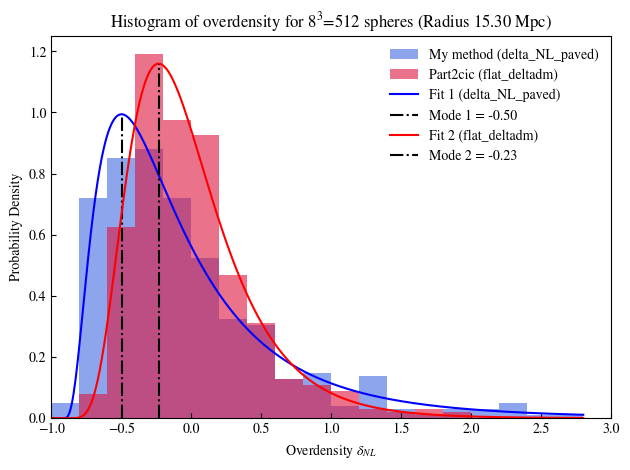

In [41]:
from scipy.stats import lognorm

plt.figure()
bin_edges = np.arange(-1, 3, 0.2)
count, bins, _ = plt.hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='royalblue', label="My method (delta_NL_paved)")
flat_deltadm = deltadm.flatten()
count_ddm, bins_ddm, _ = plt.hist(flat_deltadm, bins=bin_edges, density=True, alpha=0.6, color='crimson', label="Part2cic (flat_deltadm)")

x = np.linspace(bins[0], bins[-1], 1000)
shape_my, loc_my, scale_my = lognorm.fit(delta_NL_paved)
lognormfit_my = lognorm.pdf(x, shape_my, loc_my, scale_my)
lognorm_mode_my = x[np.argmax(lognormfit_my)]

plt.plot(x, lognormfit_my, 'b-', label="Fit 1 (delta_NL_paved)")
plt.vlines(lognorm_mode_my, 0, np.max(lognormfit_my), linestyle="dashdot", color="black", label=f"Mode 1 = {lognorm_mode_my:.2f}")

shape_p2cic, loc_p2cic, scale_p2cic = lognorm.fit(flat_deltadm)
lognormfit_p2cic = lognorm.pdf(x, shape_p2cic, loc_p2cic, scale_p2cic)
lognorm_mode_p2cic = x[np.argmax(lognormfit_p2cic)]

plt.plot(x, lognormfit_p2cic, 'r-', label="Fit 2 (flat_deltadm)")
plt.vlines(lognorm_mode_p2cic, 0, np.max(lognormfit_p2cic), linestyle="dashdot", color="black", label=f"Mode 2 = {lognorm_mode_p2cic:.2f}")

plt.title(f"Histogram of overdensity for ${Ncut}^3$={Ncut**3} {shape}s (Radius {subreg_list[0].radius:.2f} Mpc)")
plt.xlabel("Overdensity $\\delta_{NL}$")
plt.ylabel("Probability Density")
plt.xlim(-1, 3)
plt.tight_layout()
plt.legend()
plt.show()

In [42]:
print(f"{mycmf.R_to_M(15.3*h):.2e}")

3.98e+14


In [43]:
count_cut = 128

nb_iter 4


/tmp/ipykernel_3660069/1078000425.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


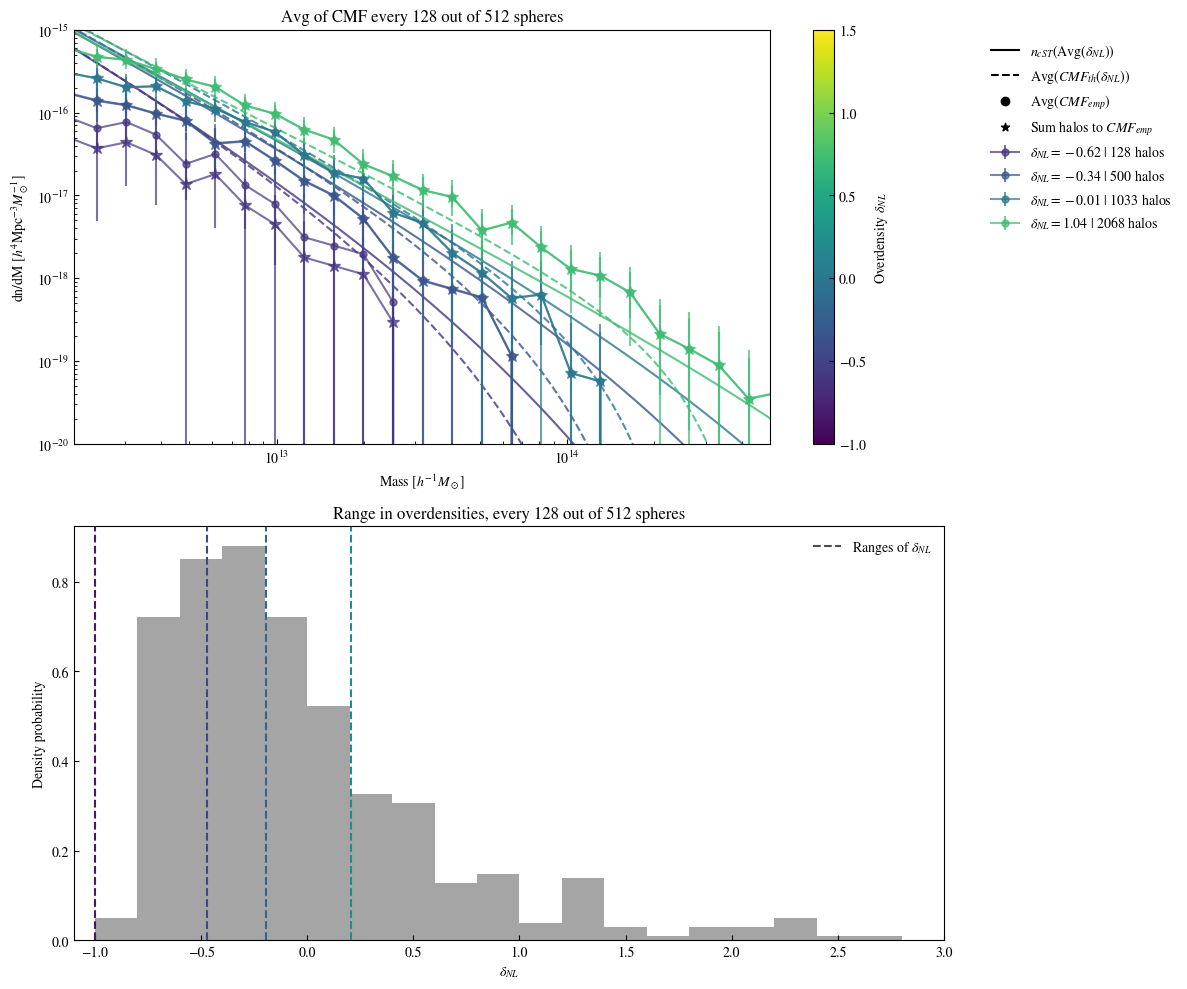

In [44]:
delta_L_paved = np.array([sr.delta_L for sr in subreg_sorted])

cmap = cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1.5)
color = cmap(norm(delta_NL_paved))

# nb_iter = len(subreg_sorted) // count_cut + 1
nb_iter = (len(subreg_sorted) + count_cut - 1) // count_cut
print("nb_iter", nb_iter)
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

if count_cut == (Ncut**3):
    ax[0].plot(bcen_hmf,mydndm_hmf,'-o',markersize=5, color = "k", label=f"HMF",alpha=0.3)

# first plot
for i in range(nb_iter):
    if i != nb_iter-1 :
        sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
        color_idx = int((count_cut*i+count_cut*(i+1))/2)
    else : 
        sr_of_interest = subreg_sorted[count_cut*i:]
        color_idx = int((count_cut*i+len(subreg_sorted))/2)
        
    halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
    nb_reg = len(sr_of_interest)
    if nb_reg != 0:

        mean_dNL = np.mean([sr.delta_NL for sr in sr_of_interest])
        mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
        # mean_dL = mycmf.compute_delta_linear(mean_dNL)
        
        ###### avg of cmf ######
        ###### theory
        ### cmf(avg(delta_L))
        avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
        ax[0].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
        
        ### avg(cmf(delta_L))
        all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
        avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
        ax[0].loglog(M_list, avg_cmf_filtered, '--', color=color[color_idx], alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
        
        ###### empirical
        ## avg of emp cmf
        avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
        avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

        ## errors
        err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
        
        upper_errors = err_sr[:, 0, :]
        lower_errors = err_sr[:, 1, :]
        
        mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
        mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
        
        ax[0].errorbar(avg_bcen_emp, avg_cmf_emp,
                yerr=[mean_lower_error, mean_upper_error], 
                fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                label=f"$\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
        
        ### avg with halos
        halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
        halos_idx = np.concatenate(halos_idx_list)
        mh_in_all_sr = mh[halos_idx]
        current_bins=np.logspace(11, 16,num=nbins)

        current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
        current_db=current_bins[1:]-current_bins[:-1]
        current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
        
        if shape == "sphere":
            V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
        elif shape == "cube":
            V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
        
        current_dndm=current_cmf/current_db/V_all_sr
        
        #error bars
        current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
        current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
        dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
        
        ax[0].errorbar(current_bcen, current_dndm,
                        yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                        fmt='*-', markersize=9, alpha=0.7, color=color[color_idx]) #f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos"


ax[0].loglog([],[], '-', color="k", label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
ax[0].loglog([],[], '--', color="k", label=f"Avg($CMF_{{th}}(\delta_{{NL}})$)")
ax[0].scatter([], [], marker='o', color="k", label=f"Avg($CMF_{{emp}}$)")
ax[0].scatter([], [], marker='*', color="k", label=f"Sum halos to $CMF_{{emp}}$")

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label(f'Overdensity $\delta_{{NL}}$')


ax[0].set_title(f"Avg of CMF every {count_cut} out of {Ncut**3} {shape}s")
ax[0].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
ax[0].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
ax[0].set_xlim([2e12,5e14])
ax[0].set_ylim([1e-20,1e-15])
ax[0].legend(bbox_to_anchor=(1.3, 1), loc='upper left')
# ax[0].legend()

# second plot
bin_edges = np.arange(-1, 3, 0.2)
count, bins, _ = ax[1].hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='dimgrey')

ax[1].axvline(-1, color=color[0], linestyle='dashed')

for i in range(nb_iter):
    dNL_range_left = delta_NL_paved[count_cut*(i)-1]
    ax[1].axvline(dNL_range_left, color=color[count_cut*(i)-1], linestyle='dashed')

ax[1].plot([],[], color='black', linestyle='dashed', alpha=0.7, label="Ranges of $\delta_{NL}$")

ax[1].set_xlim(-1.1, 3)
ax[1].set_title(f"Range in overdensities, every {count_cut} out of {Ncut**3} {shape}s")
ax[1].set_xlabel(r"$\delta_{NL}$")
ax[1].set_ylabel("Density probability")
ax[1].legend()

plt.tight_layout()
if 0 :
    plt.savefig(f"./images/avg_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.pdf")
    plt.savefig(f"./images/avg_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.png")
plt.show()

/tmp/ipykernel_3660069/1482944187.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


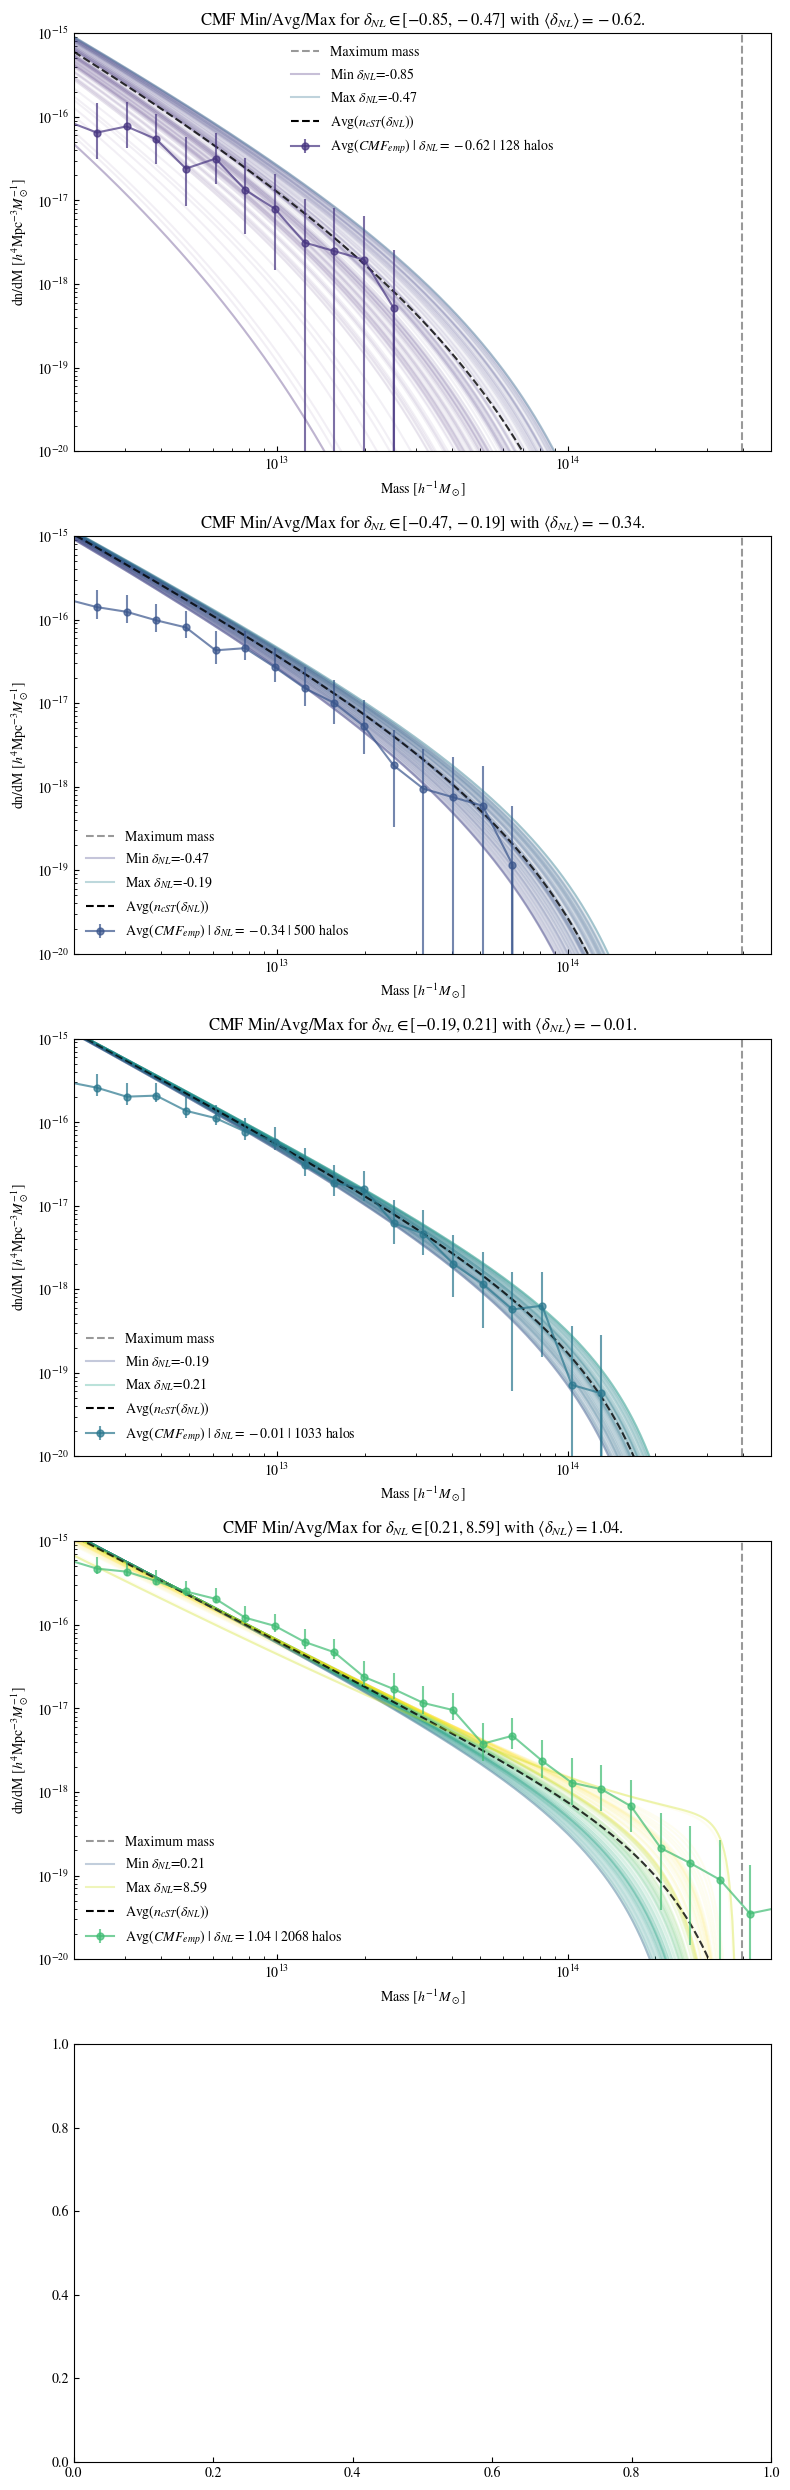

In [61]:
fig, ax = plt.subplots(nb_iter, 1, figsize=(8, 5 * nb_iter))  

if nb_iter == 1:
    ax = [ax]

for i in range(nb_iter):
    if i != nb_iter-1:
        sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
        color_idx = int((count_cut*i+count_cut*(i+1))/2)
    else:
        sr_of_interest = subreg_sorted[count_cut*i:]
        color_idx = int((count_cut*i+len(subreg_sorted))/2)
    halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
    
    if len(sr_of_interest) != 0:
        delta_NL_values = np.array([sr.delta_NL for sr in sr_of_interest if sr.cmf_th_cST is not None])
        cmf_values = np.array([sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None])
        
        if len(cmf_values) > 0:
            ax[i].axvline(mycmf.R_to_M(radius_sr*h), color="k", alpha=0.4, linestyle='dashed', label = "Maximum mass")
            
            dNL_sr_of_interest = np.array([sr.delta_NL for sr in sr_of_interest])
            mean_dNL = np.mean(dNL_sr_of_interest)
            mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
            # mean_dL = mycmf.compute_delta_linear(mean_dNL)
            
            # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
            # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
            all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
            all_cmf_emp = [sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None]
            all_bcen_emp = [sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None]
            
            for idx,cmf_th in enumerate(all_cmf_th):
                ax[i].loglog(M_list, cmf_th, '-', color=color[count_cut*i+idx], alpha=0.065)
                
            # for idx, cmf_emp in enumerate(all_cmf_emp):
                # ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.8, color=color[count_cut*i+idx])
                # if i==(nb_iter-1):
                #     print(cmf_emp)
            avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
            ax[i].loglog(M_list, avg_cmf_filtered, '--', color="k", alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
            
            # from simulation
            avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
            avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

            ##errors
            err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
            
            upper_errors = err_sr[:, 0, :]
            lower_errors = err_sr[:, 1, :]
            
            mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
            mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
            
            ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                    yerr=[mean_lower_error, mean_upper_error], 
                    fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                    label=f"Avg($CMF_{{emp}}$) | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
            
            ### avg with halos
            halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
            halos_idx = np.concatenate(halos_idx_list)
            mh_in_all_sr = mh[halos_idx]
            current_bins=np.logspace(11, 16,num=nbins)

            current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
            current_db=current_bins[1:]-current_bins[:-1]
            current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
            
            if shape == "sphere":
                V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
            elif shape == "cube":
                V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
                
            current_dndm=current_cmf/current_db/V_all_sr
            
            #error bars
            current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
            
            # ax[i].errorbar(current_bcen, current_dndm,
            #                 yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
            #                 fmt='*-', markersize=7, alpha=0.7, color=color[color_idx],
            #                 label=f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
            
            # ## min and max
            max_index = np.argmax(delta_NL_values)
            min_index = np.argmin(delta_NL_values)
            
            max_cmf = sr_of_interest[max_index].cmf_th_cST
            min_cmf = sr_of_interest[min_index].cmf_th_cST
            
            ax[i].loglog(M_list, min_cmf, '-', color=color[int(color_idx/2)], alpha=0.3, label=f"Min $\delta_{{NL}}$={delta_NL_values[min_index]:.2f}")
            ax[i].loglog(M_list, max_cmf, '-', color=color[int((color_idx+len(color))/2)], alpha=0.3, label=f"Max $\delta_{{NL}}$={delta_NL_values[max_index]:.2f}")
            # ax[i].fill_between(M_list,min_cmf,max_cmf, color=color[color_idx], alpha=0.15)
            
            # ax[i].loglog([],[], '-', color=color[color_idx], label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
            ax[i].loglog([],[], '--', color="k", label=f"Avg($n_{{cST}}(\delta_{{NL}})$)")
            
            ax[i].set_title(f"CMF Min/Avg/Max for $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
            ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
            ax[i].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
            ax[i].set_xlim([2e12,5e14])
            ax[i].set_ylim([1e-20,1e-15])
            ax[i].legend()

if 0 :
    plt.savefig(f"./images/minavgmax_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.pdf")
    plt.savefig(f"./images/minavgmax_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.png")
    print(f"Wrote as : minavgmax_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s ")

plt.tight_layout()
plt.show()


In [62]:
indiv_range = 0.5
lower_bound = -1
upper_bound = 2

dNL_range = np.arange(lower_bound, upper_bound, indiv_range)
dNL_range

array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5])

nb_iter 5
113


/tmp/ipykernel_3660069/3478605643.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


213
105
40
41


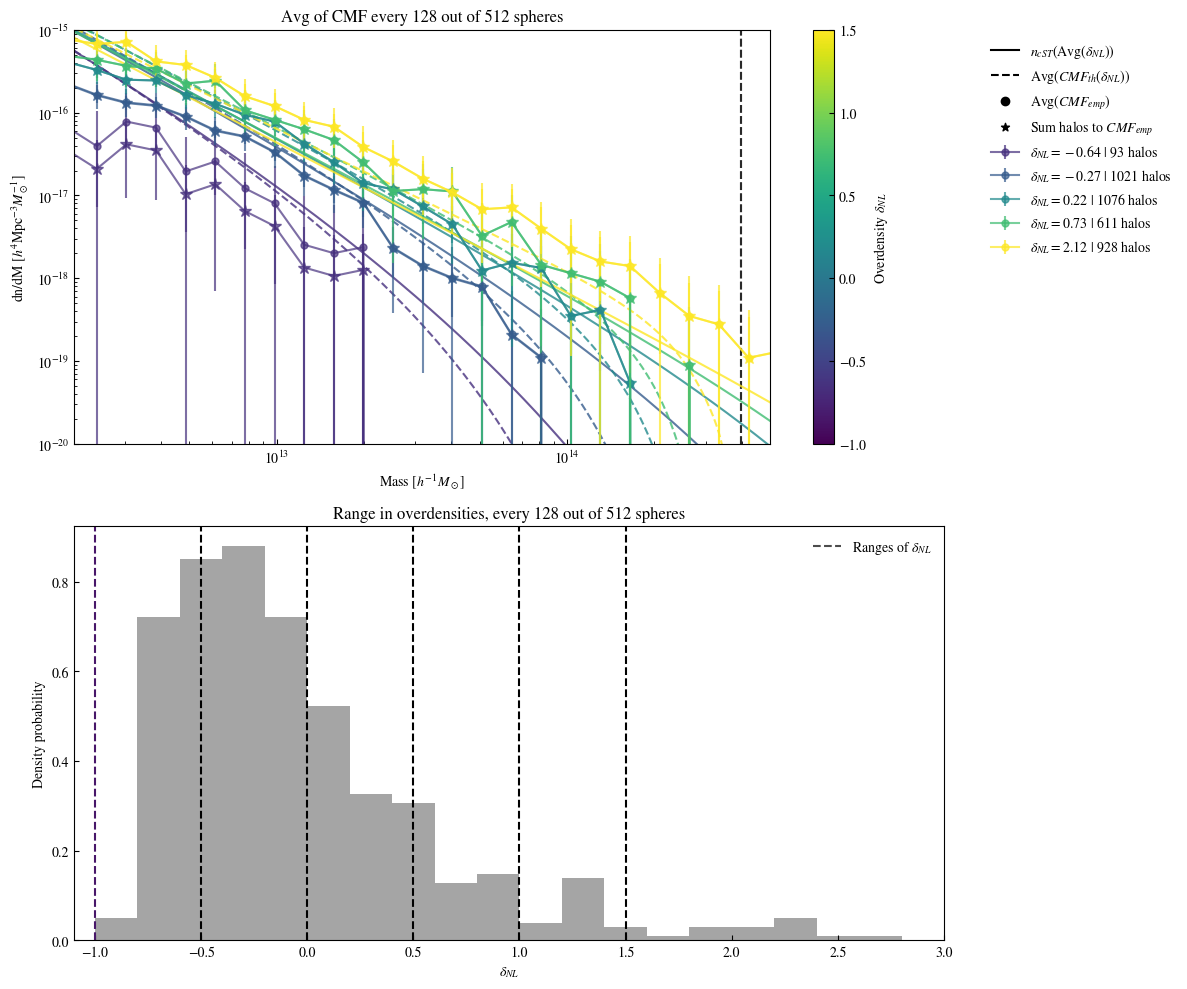

In [63]:
cmap = cm.viridis
norm = plt.Normalize(vmin=-1, vmax=1.5)
color = cmap(norm(delta_NL_paved))

# nb_iter = len(subreg_sorted) // count_cut + 1
nb_iter = len(dNL_range) - 1
print("nb_iter", nb_iter)
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

if count_cut == (Ncut**3):
    ax[0].plot(bcen_hmf,mydndm_hmf,'-o',markersize=5, color = "k", label=f"HMF",alpha=0.3)

# first plot
for i in range(nb_iter):
    if i != nb_iter-1 :
    # if 1 :
        w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
        sr_of_interest = subreg_sorted[w]
        color_idx = int((w[0]+w[-1])/2)
    else :
        w = np.where(delta_NL_paved >= dNL_range[i])[0]
        sr_of_interest = subreg_sorted[w]
        color_idx = int((w[0]+len(subreg_sorted))/2)
        
    halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
    nb_reg = len(sr_of_interest)
    if nb_reg != 0:
        print(len(sr_of_interest))
        
        ax[0].axvline(mycmf.R_to_M(radius_sr*h), alpha=0.3, color="k", linestyle='dashed')
        
        mean_dNL = np.mean([sr.delta_NL for sr in sr_of_interest])
        mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
        # mean_dL = mycmf.compute_delta_linear(mean_dNL)
        
        ###### avg of cmf ######
        ###### theory
        ### cmf(avg(delta_L))
        avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
        ax[0].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
        
        ### avg(cmf(delta_L))
        all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
        avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
        ax[0].loglog(M_list, avg_cmf_filtered, '--', color=color[color_idx], alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
        
        ###### empirical
        ## avg of emp cmf
        avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
        avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

        ## errors
        err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
        
        upper_errors = err_sr[:, 0, :]
        lower_errors = err_sr[:, 1, :]
        
        mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
        mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
        
        ax[0].errorbar(avg_bcen_emp, avg_cmf_emp,
                yerr=[mean_lower_error, mean_upper_error], 
                fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                label=f"$\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
        
        ### avg with halos
        halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
        halos_idx = np.concatenate(halos_idx_list)
        mh_in_all_sr = mh[halos_idx]
        current_bins=np.logspace(11, 16,num=nbins)

        current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
        current_db=current_bins[1:]-current_bins[:-1]
        current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
        
        if shape == "sphere":
            V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
        elif shape == "cube":
            V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
        
        current_dndm=current_cmf/current_db/V_all_sr
        
        #error bars
        current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
        current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
        dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
        
        ax[0].errorbar(current_bcen, current_dndm,
                        yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                        fmt='*-', markersize=9, alpha=0.7, color=color[color_idx]) #f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos"


ax[0].loglog([],[], '-', color="k", label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
ax[0].loglog([],[], '--', color="k", label=f"Avg($CMF_{{th}}(\delta_{{NL}})$)")
ax[0].scatter([], [], marker='o', color="k", label=f"Avg($CMF_{{emp}}$)")
ax[0].scatter([], [], marker='*', color="k", label=f"Sum halos to $CMF_{{emp}}$")

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label(f'Overdensity $\delta_{{NL}}$')


ax[0].set_title(f"Avg of CMF every {count_cut} out of {Ncut**3} {shape}s")
ax[0].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
ax[0].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
ax[0].set_xlim([2e12,5e14])
ax[0].set_ylim([1e-20,1e-15])
ax[0].legend(bbox_to_anchor=(1.3, 1), loc='upper left')
# ax[0].legend()

# second plot
bin_edges = np.arange(-1, 3, 0.2)
count, bins, _ = ax[1].hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='dimgrey')

ax[1].axvline(-1, color=color[0], linestyle='dashed')

for i in range(nb_iter):
    ax[1].axvline(lower_bound+(i+1)*indiv_range, color="k", linestyle='dashed')

ax[1].plot([],[], color='black', linestyle='dashed', alpha=0.7, label="Ranges of $\delta_{NL}$")

ax[1].set_xlim(-1.1, 3)
ax[1].set_title(f"Range in overdensities, every {count_cut} out of {Ncut**3} {shape}s")
ax[1].set_xlabel(r"$\delta_{NL}$")
ax[1].set_ylabel("Density probability")
ax[1].legend()

plt.tight_layout()
if 0 :
    plt.savefig(f"./images/avg_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.pdf")
    plt.savefig(f"./images/avg_cmf_every_{count_cut}_out_of_{len(subreg_sorted)}_{shape}s.png")
plt.show()

In [ ]:
def plot_sub_cmf(subreg_sorted, arg, method="range"):
    '''
    args is either :
        -a list of the bins of delta_NL if the method is range
        -a number of subregions to cut if the method is number
    method : "range" or "number"
    '''
    cmap = cm.viridis
    norm = plt.Normalize(vmin=-1, vmax=1.5)
    color = cmap(norm(delta_NL_paved))
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    if method == "range":
        dNL_range = arg
        nb_iter = len(dNL_range) - 1
        ax[0].set_title(f"Avg of CMF every for different ranges of $\delta_{{NL}}\in [{arg[0]},{arg[-1]}]$")
        ax[1].set_title(f"Range in overdensities in $\delta_{{NL}}\in [{arg[0]},{arg[-1]}]$")
    elif method == "number":
        count_cut = arg
        nb_iter = len(subreg_sorted) // count_cut + 1
        if count_cut == (Ncut**3):
            ax[0].plot(bcen_hmf,mydndm_hmf,'-o',markersize=5, color = "k", label=f"HMF",alpha=0.3)
        ax[0].set_title(f"Avg of CMF every {count_cut} out of {Ncut**3} {shape}s")
        ax[1].set_title(f"Range in overdensities, every {count_cut} out of {Ncut**3} {shape}s")


    print("nb_iter", nb_iter)

    # first plot
    for i in range(nb_iter):
        if method == "range":
            if i != nb_iter-1 :
                w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
                sr_of_interest = subreg_sorted[w]
                color_idx = int((w[0]+w[-1])/2)
            else :
                w = np.where(delta_NL_paved >= dNL_range[i])[0]
                sr_of_interest = subreg_sorted[w]
                color_idx = int((w[0]+len(subreg_sorted))/2)
        elif method == "number":
            if i != nb_iter-1 :
                sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
                color_idx = int((count_cut*i+count_cut*(i+1))/2)
            else : 
                sr_of_interest = subreg_sorted[count_cut*i:]
                color_idx = int((count_cut*i+len(subreg_sorted))/2)
        
        halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
        nb_reg = len(sr_of_interest)
        if nb_reg != 0:
            ax[i].axvline(mycmf.R_to_M(radius_sr*h), alpha=0.3,  color="k", linestyle='dashed')
            
            mean_dNL = np.mean([sr.delta_NL for sr in sr_of_interest])
            mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
            
            ###### avg of cmf ######
            ###### theory
            ### cmf(avg(delta_L))
            avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
            ax[0].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
            
            ### avg(cmf(delta_L))
            all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
            avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
            ax[0].loglog(M_list, avg_cmf_filtered, '--', color=color[color_idx], alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
            
            ###### empirical
            ## avg of emp cmf
            avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
            avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

            ## errors
            err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
            
            upper_errors = err_sr[:, 0, :]
            lower_errors = err_sr[:, 1, :]
            
            mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
            mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
            
            ax[0].errorbar(avg_bcen_emp, avg_cmf_emp,
                    yerr=[mean_lower_error, mean_upper_error], 
                    fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                    label=f"$\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
            
            ### avg with halos
            halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
            halos_idx = np.concatenate(halos_idx_list)
            mh_in_all_sr = mh[halos_idx]
            current_bins=np.logspace(11, 16,num=nbins)

            current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
            current_db=current_bins[1:]-current_bins[:-1]
            current_cmf, current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
            
            if shape == "sphere":
                V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
            elif shape == "cube":
                V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
            
            current_dndm=current_cmf/current_db/V_all_sr
            
            #error bars
            current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
            dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
            
            ax[0].errorbar(current_bcen, current_dndm,
                            yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                            fmt='*-', markersize=9, alpha=0.7, color=color[color_idx]) #f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos"

    ax[0].loglog([],[], '-', color="k", label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
    ax[0].loglog([],[], '--', color="k", label=f"Avg($CMF_{{th}}(\delta_{{NL}})$)")
    ax[0].scatter([], [], marker='o', color="k", label=f"Avg($CMF_{{emp}}$)")
    ax[0].scatter([], [], marker='*', color="k", label=f"Sum halos to $CMF_{{emp}}$")

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax[0])
    cbar.set_label(f'Overdensity $\delta_{{NL}}$')

    ax[0].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
    ax[0].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
    ax[0].set_xlim([2e12,5e14])
    ax[0].set_ylim([1e-20,1e-15])
    ax[0].legend(bbox_to_anchor=(1.3, 1), loc='upper left')
    # ax[0].legend()

    # second plot
    bin_edges = np.arange(-1, 3, 0.2)
    count, bins, _ = ax[1].hist(delta_NL_paved, bins=bin_edges, density=True, alpha=0.6, color='dimgrey')

    ax[1].axvline(-1, color=color[0], linestyle='dashed')
    
    for i in range(nb_iter):
        if method == "range":
            ax[1].axvline(lower_bound+(i+1)*indiv_range, color="k", linestyle='dashed')
        elif method == "number":
            dNL_range_left = delta_NL_paved[count_cut*(i)-1]
            ax[1].axvline(dNL_range_left, color=color[count_cut*(i)-1], linestyle='dashed')
    ax[1].plot([],[], color='black', linestyle='dashed', alpha=0.7, label="Ranges of $\delta_{NL}$")

    ax[1].set_xlim(-1.1, 3)
    
    ax[1].set_xlabel(r"$\delta_{NL}$")
    ax[1].set_ylabel("Density probability")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1153794013.py, line 51)

nb_iter 5


/tmp/ipykernel_3660069/1802465917.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


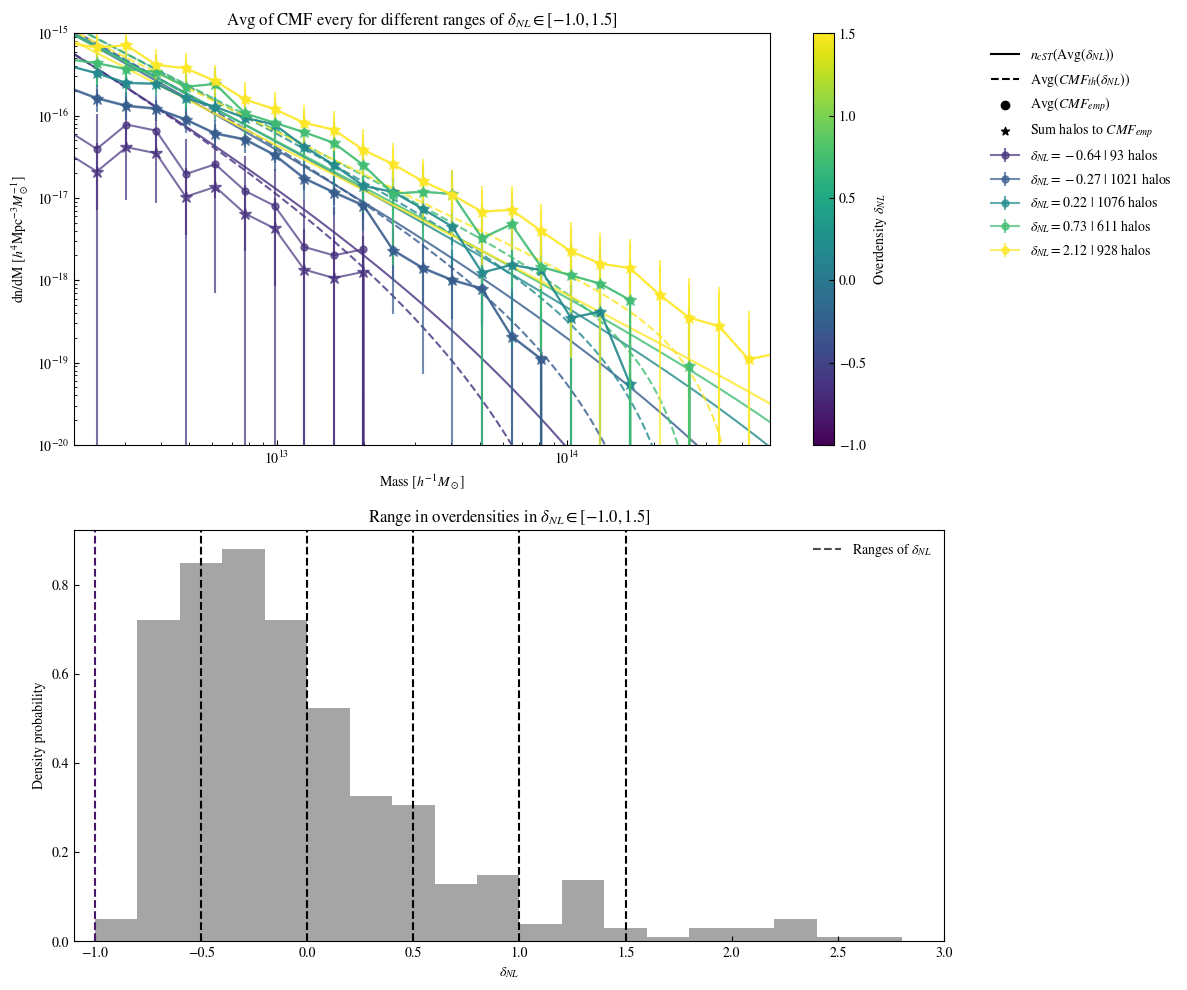

In [ ]:
# plot_sub_cmf(subreg_sorted, 128, method="number")

indiv_range = 0.5
lower_bound = -1
upper_bound = 2
dNL_range = np.arange(lower_bound, upper_bound, indiv_range)
plot_sub_cmf(subreg_sorted, dNL_range, method="range")

In [65]:
def plot_every_sub_cmf(subreg_sorted, arg, method="range"):
    '''
    args is either :
        -a list of the bins of delta_NL if the method is range
        -a number of subregions to cut if the method is number
    method : "range" or "number"
    '''
    
    if method == "range":
        dNL_range = arg
        nb_iter = len(dNL_range) - 1
    elif method == "number":
        count_cut = arg
        nb_iter = (len(subreg_sorted) // count_cut + 1 )-1
        
    cmap = cm.viridis
    norm = plt.Normalize(vmin=-1, vmax=1.5)
    color = cmap(norm(delta_NL_paved))
    fig, ax = plt.subplots(nb_iter, 1, figsize=(8, 5 * nb_iter))  
        

    print("nb_iter", nb_iter)
    
    if nb_iter == 1:
        ax = [ax]

    for i in range(nb_iter):
        if method == "range":
            if i != nb_iter-1 :
                w = np.where((delta_NL_paved >= dNL_range[i]) & (delta_NL_paved < dNL_range[i+1]))[0]
                sr_of_interest = subreg_sorted[w]
                color_idx = int((w[0]+w[-1])/2)
            else :
                w = np.where(delta_NL_paved >= dNL_range[i])[0]
                sr_of_interest = subreg_sorted[w]
                color_idx = int((w[0]+len(subreg_sorted))/2)
        elif method == "number":
            if i != nb_iter-1 :
                sr_of_interest = subreg_sorted[count_cut*i:count_cut*(i+1)]
                color_idx = int((count_cut*i+count_cut*(i+1))/2)
            else : 
                sr_of_interest = subreg_sorted[count_cut*i:]
                color_idx = int((count_cut*i+len(subreg_sorted))/2)
                
        halos_found = np.sum([sr.num_halos for sr in sr_of_interest])
        nb_reg = len(sr_of_interest)
        
        if len(sr_of_interest) != 0:
            delta_NL_values = np.array([sr.delta_NL for sr in sr_of_interest if sr.cmf_th_cST is not None])
            cmf_values = np.array([sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None])
            
            if len(cmf_values) > 0:
                ax[i].axvline(mycmf.R_to_M(radius_sr*h), color="k", linestyle='dashed', alpha=0.3)
                
                dNL_sr_of_interest = np.array([sr.delta_NL for sr in sr_of_interest])
                mean_dNL = np.mean(dNL_sr_of_interest)
                mean_dL = np.mean([sr.delta_L for sr in sr_of_interest])
                
                # avg_cmf_from_dL = [mycmf.cmfcalc(M_list[ii], kh, pk, (sr_of_interest[0].radius*h)*nb_reg**(1/3), mean_dL, model="cST") for ii in range(len(M_list))]
                # ax[i].loglog(M_list, avg_cmf_from_dL, '-', color=color[color_idx], alpha=0.8)
                all_cmf_th = [sr.cmf_th_cST for sr in sr_of_interest if sr.cmf_th_cST is not None]
                all_cmf_emp = [sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None]
                all_bcen_emp = [sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None]
                
                for idx,cmf_th in enumerate(all_cmf_th):
                    if method=="range":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[w[0]+idx], alpha=0.065)
                    elif method=="number":
                        ax[i].loglog(M_list, cmf_th, '-', color=color[count_cut*i+idx], alpha=0.065)
                
                # for idx, cmf_emp in enumerate(all_cmf_emp):
                    # ax[i].loglog(all_bcen_emp[idx], cmf_emp, '-o', markersize=5, alpha=0.8, color=color[count_cut*i+idx])
                    # if i==(nb_iter-1):
                    #     print(cmf_emp)
                avg_cmf_filtered = np.mean(all_cmf_th, axis=0)
                ax[i].loglog(M_list, avg_cmf_filtered, '--', color="k", alpha=0.8) #, label = f"$\delta_L={mean_dL_directly:.2f}$"
                
                # from simulation
                avg_cmf_emp = np.mean([sr.cmf_emp for sr in sr_of_interest if sr.cmf_emp is not None], axis=0)
                avg_bcen_emp = np.mean([sr.bcen_emp for sr in sr_of_interest if sr.bcen_emp is not None], axis=0)

                ##errors
                err_sr = np.array([sr.err_emp for sr in sr_of_interest if sr.err_emp is not None])
                
                upper_errors = err_sr[:, 0, :]
                lower_errors = err_sr[:, 1, :]
                
                mean_upper_error = np.sqrt(np.sum(upper_errors ** 2, axis=0)) / len(err_sr)
                mean_lower_error = np.sqrt(np.sum(lower_errors ** 2, axis=0)) / len(err_sr)
                
                ax[i].errorbar(avg_bcen_emp, avg_cmf_emp,
                        yerr=[mean_lower_error, mean_upper_error], 
                        fmt='o-', markersize=5, alpha=0.7, color=color[color_idx],
                        label=f"Avg($CMF_{{emp}}$) | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
                
                ### avg with halos
                halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])
                halos_idx = np.concatenate(halos_idx_list)
                mh_in_all_sr = mh[halos_idx]
                current_bins=np.logspace(11, 16,num=nbins)

                current_bcen=0.5*(current_bins[1:]+current_bins[:-1])
                current_db=current_bins[1:]-current_bins[:-1]
                current_cmf,current_bin_edges = np.histogram(mh_in_all_sr*h,bins=current_bins) 
                
                if shape == "sphere":
                    V_all_sr = nb_reg * 4/3*np.pi*(sr_of_interest[0].radius*h)**3
                elif shape == "cube":
                    V_all_sr = nb_reg * (sr_of_interest[0].radius*h)**3
                    
                current_dndm=current_cmf/current_db/V_all_sr
                
                #error bars
                current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/V_all_sr #3 sigma dispersion
                dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
                
                # ax[i].errorbar(current_bcen, current_dndm,
                #                 yerr=[current_dndm - dndm_err[1], dndm_err[0] - current_dndm], 
                #                 fmt='*-', markersize=7, alpha=0.7, color=color[color_idx],
                #                 label=f"Sum halos to $CMF_{{emp}}$ | $\delta_{{NL}}={mean_dNL:.2f}$ | {halos_found} halos")
                
                # ## min and max
                max_index = np.argmax(delta_NL_values)
                min_index = np.argmin(delta_NL_values)
                
                max_cmf = sr_of_interest[max_index].cmf_th_cST
                min_cmf = sr_of_interest[min_index].cmf_th_cST
                
                ax[i].loglog(M_list, min_cmf, '-', color=color[int(color_idx/2)], alpha=0.3, label=f"Min $\delta_{{NL}}$={delta_NL_values[min_index]:.2f}")
                ax[i].loglog(M_list, max_cmf, '-', color=color[int((color_idx+len(color))/2)], alpha=0.3, label=f"Max $\delta_{{NL}}$={delta_NL_values[max_index]:.2f}")
                # ax[i].fill_between(M_list,min_cmf,max_cmf, color=color[color_idx], alpha=0.15)
                
                # ax[i].loglog([],[], '-', color=color[color_idx], label=f"$n_{{cST}}$(Avg($\delta_{{NL}}$))")
                ax[i].loglog([],[], '--', color="k", label=f"Avg($n_{{cST}}(\delta_{{NL}})$)")
                if method=="range":
                    ax[i].set_title(f"CMF Min/Avg/Max for {len(sr_of_interest)} subreg with $\delta_{{NL}} \in [{arg[0]},{arg[-1]}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                elif method == "number":
                    ax[i].set_title(f"CMF Min/Avg/Max for {len(sr_of_interest)} subreg with $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                    
                # ax[i].set_title(f"CMF Min/Avg/Max for $\delta_{{NL}} \in [{delta_NL_values[min_index]:.2f}, {delta_NL_values[max_index]:.2f}]$ with $\left\langle \delta_{{NL}} \\right\\rangle={mean_dNL:.2f}$.")
                ax[i].set_xlabel(r"Mass $[h^{-1}M_\odot]$")
                ax[i].set_ylabel(r"dn/dM $[h^{4}{\rm Mpc}^{-3}M_\odot^{-1}]$")
                ax[i].set_xlim([2e12,5e14])
                ax[i].set_ylim([1e-20,1e-15])
                ax[i].legend()


    plt.tight_layout()
    plt.show()


nb_iter 5


/tmp/ipykernel_3660069/3748955494.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  halos_idx_list = np.array([sr.halo_indices for sr in sr_of_interest if len(sr.halo_indices) > 0])


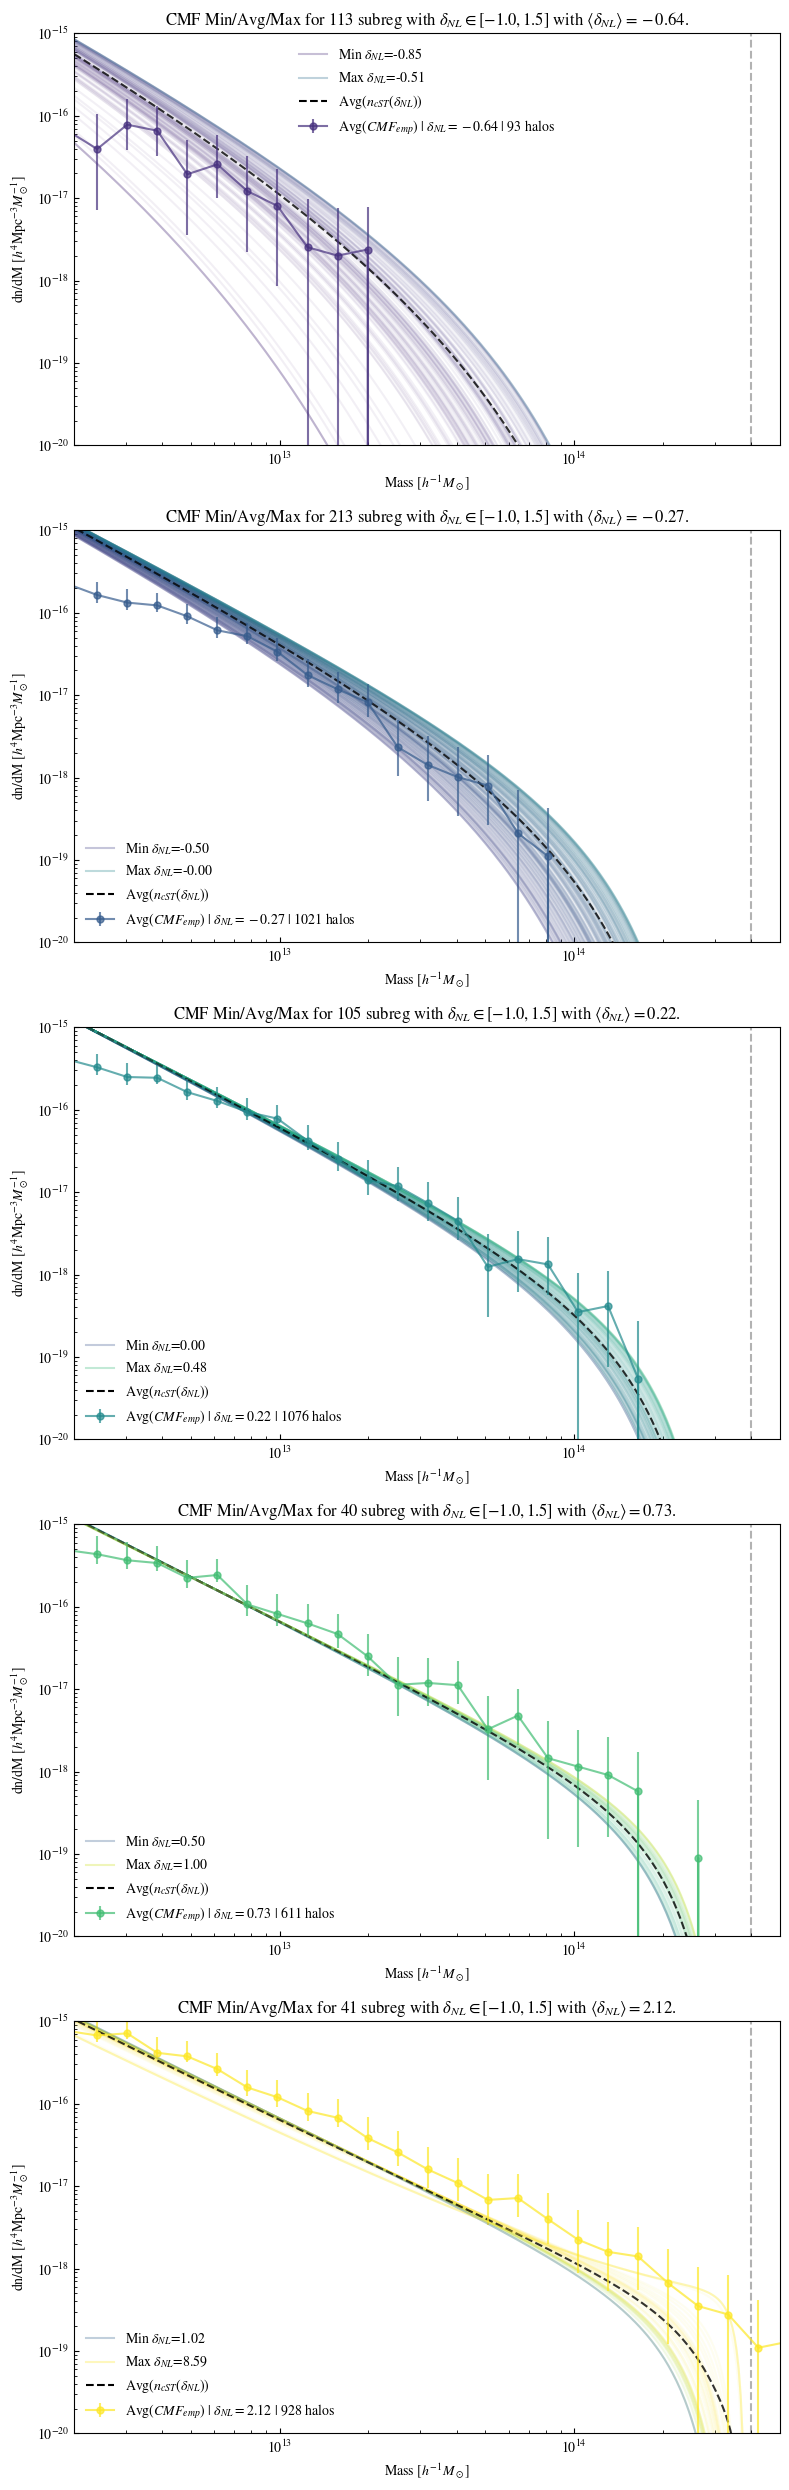

In [66]:
# plot_every_sub_cmf(subreg_sorted, 128, method="number")

plot_every_sub_cmf(subreg_sorted, dNL_range, method="range")

# R200

In [52]:
def linear_overdensity(center_sphere, radius_sphere, grid_size, part_pos_mpc,  rho_mean):
    rho = density_in_shape(center_sphere, radius_sphere, grid_size, part_pos_mpc)
    delta_NL = rho / rho_mean
    delta_L = mycmf.compute_delta_linear(delta_NL)
    return delta_L

def compute_dist_from_center(center_sphere, grid_size, pos_mpc):
    cx, cy, cz = center_sphere
    x, y, z = pos_mpc[:,0], pos_mpc[:,1], pos_mpc[:,2]
    xsize, ysize, zsize = grid_size
    
    dx = np.minimum(abs(x - cx), xsize - abs(x - cx)) #either normal distance or substracting the grid_size 
    dy = np.minimum(abs(y - cy), ysize - abs(y - cy))
    dz = np.minimum(abs(z - cz), zsize - abs(z - cz))
    
    d = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return d

In [53]:
def compute_R200_mine(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, print_convergence = True):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    halo_mass = mh[halo_idx] #Msun
    R200 = R200_init #Mpc
    R200_max = R200
    R200_min = 1e-3

    parts_in_halo = idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
    delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Computing the R200 of the halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun...")
    
    while abs(delta_L - 200) > 5e-2:
        if print_convergence:
            print(f"Current overdensity of {delta_L:.2f} with a R200 = {R200:.2f} Mpc and with {len(parts_in_halo)} particles in it.")
        # R200= R200 / 2
        if delta_L < 200:
            R200_max = R200
        else:
            R200_min = R200
        
        R200 = (R200_max + R200_min) / 2  

        parts_in_halo = idx_of_part_in_shape(halo_pos, R200, grid_size, part_pos_mpc)
        delta_L = linear_overdensity(halo_pos, R200, grid_size, part_pos_mpc, rho_mean)
    print(f"Convergence over ! Overdensity of : {delta_L:.1f}.")
    print(f"Halo of center {np.round(halo_pos,0)} and mass {halo_mass:.2e} Msun has a R200 of {R200:.2f} Mpc with {len(parts_in_halo)} particles in it.")
    return R200

In [54]:
def compute_R200(halo_idx, R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart):
    halo_pos = [xh_mpc[halo_idx], yh_mpc[halo_idx], zh_mpc[halo_idx]]
    nb_part_init = idx_of_part_in_shape(halo_pos, R200_init, grid_size, part_pos_mpc)
    
    ri = compute_dist_from_center(halo_pos, grid_size, part_pos_mpc[nb_part_init])
    ri_sorted = np.sort(ri)
    
    N = np.array([i for i in range(1,len(nb_part_init)+1)])
    
    rho_region = mpart/2e30 * N / (4/3*np.pi*ri_sorted**3)
    rho_quotient = rho_region / rho_mean
    
    below_200 = np.where(rho_quotient < 200)[0]
    
    if len(below_200) == 0 :
        print("No R200 found with this R200_init, increasing R200_init...")
        R200 = compute_R200(halo_idx, 2*R200_init, grid_size, part_pos_mpc, rho_mean, mpart=mpart)
        return R200
    
    R200 = ri_sorted[below_200[0]]
    
    return R200

In [55]:
halo_of_interest = 0
R200init = 10 #Mpc
halo_center = [xh_mpc[halo_of_interest], yh_mpc[halo_of_interest], zh_mpc[halo_of_interest]]

R200test = compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3)

In [56]:
print(compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3))

4.4013968


In [57]:
# print(compute_R200_mine(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3,print_convergence=False))

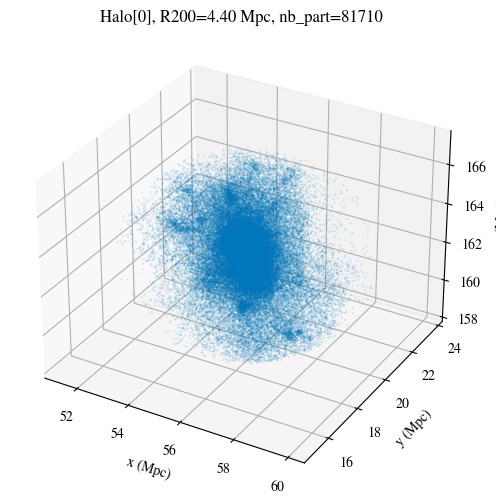

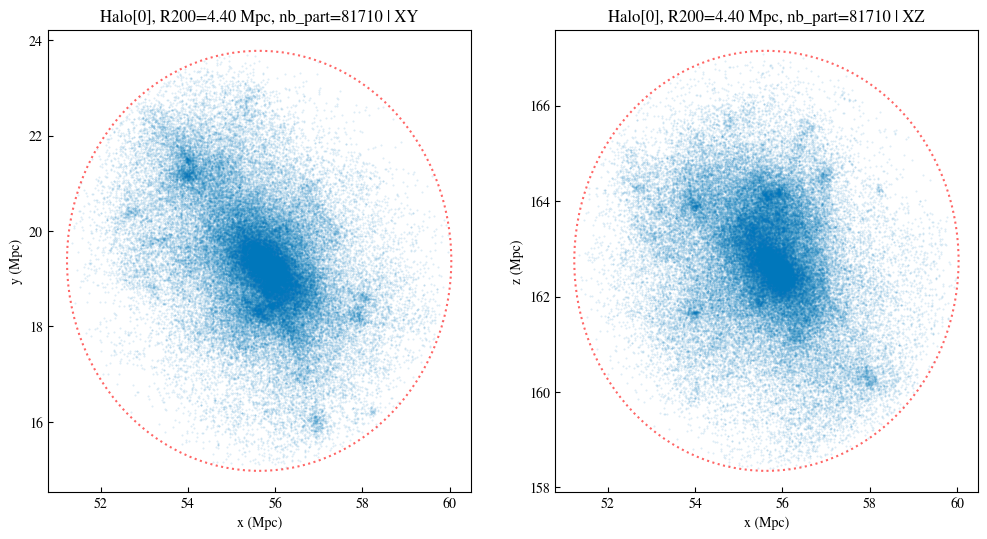

In [58]:
idx_part_in_HOI = idx_of_part_in_shape(halo_center, R200test, grid_size, part_pos_mpc)
part_alpha = 0.15
part_size = 0.2


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
ax.set_xlabel("x (Mpc)")
ax.set_ylabel("y (Mpc)")
ax.set_zlabel("z (Mpc)")
ax.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)}")

fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

ax_xy.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[1]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xy.add_patch(circle)
ax_xy.set_xlabel("x (Mpc)")
ax_xy.set_ylabel("y (Mpc)")
ax_xy.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XY")

ax_xz.scatter(x_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
circle = plt.Circle((halo_center[0], halo_center[2]), R200test, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
ax_xz.add_patch(circle)
ax_xz.set_xlabel("x (Mpc)")
ax_xz.set_ylabel("z (Mpc)")
ax_xz.set_title(f"Halo[{halo_of_interest}], R200={R200test:.2f} Mpc, nb_part={len(idx_part_in_HOI)} | XZ")

plt.show()

In [59]:
# R200init = 10 #Mpc

# for i in range(0, 100, 20):
#     halo_of_interest = i
#     halo_center = [xh_mpc[halo_of_interest], yh_mpc[halo_of_interest], zh_mpc[halo_of_interest]]
#     current_R200 = compute_R200(halo_of_interest, R200init, grid_size, part_pos_mpc, rho_MsunMpc3)
#     idx_part_in_HOI = idx_of_part_in_sphere(halo_center, current_R200, grid_size, part_pos_mpc)
#     nb_part = len(idx_part_in_HOI)
#     if nb_part < 500:
#         part_size = 10
#         part_alpha = 0.8
#     elif nb_part < 5000:
#         part_size = 2
#         part_alpha = 0.3
#     else:
#         part_size = 0.2
#         part_alpha = 0.1


#     fig, (ax_xy, ax_xz) = plt.subplots(1, 2, figsize=(12, 6))

#     ax_xy.scatter(x_mpc[idx_part_in_HOI], y_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
#     circle = plt.Circle((halo_center[0], halo_center[1]), current_R200, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
#     ax_xy.add_patch(circle)
#     ax_xy.set_xlabel("x (Mpc)")
#     ax_xy.set_ylabel("y (Mpc)")
#     ax_xy.set_title(f"Halo[{halo_of_interest}], R200={current_R200:.2f} Mpc, nb_part={nb_part} | XY")

#     ax_xz.scatter(x_mpc[idx_part_in_HOI], z_mpc[idx_part_in_HOI], alpha=part_alpha, s=part_size)
#     circle = plt.Circle((halo_center[0], halo_center[2]), current_R200, color='r',  alpha = 0.6, linestyle='dotted', fill=False, linewidth=1.5)
#     ax_xz.add_patch(circle)
#     ax_xz.set_xlabel("x (Mpc)")
#     ax_xz.set_ylabel("z (Mpc)")
#     ax_xz.set_title(f"Halo[{halo_of_interest}], R200={current_R200:.2f} Mpc, nb_part={nb_part} | XZ")

#     plt.show()

In [60]:
# idx_halos_paved = []
# density_paved = []
# delta_NL_paved = []
# delta_L_paved = []
# cmf_emp = []
# err_emp = []
# bcen_emp = []
# cmf_th = []
# bins_emp = []
# nb_halos = []

# paved_centers, paved_radius = paving_domain(Ncut, grid_size)
# nb_sphere = len(paved_centers)

# print(f"Computing values for {nb_sphere} spheres of radius {paved_radius:.2f} Mpc...")
# current_nb_part_tot=0
# for current_center in tqdm(paved_centers):

#     cx, cy, cz = current_center
    
#     if shape == "cube":
#         w = np.where((part_pos_mpc[:, 0] >= cx - paved_radius) & (part_pos_mpc[:, 0] < cx + paved_radius) &(part_pos_mpc[:, 1] >= cy - paved_radius) & (part_pos_mpc[:, 1] < cy + paved_radius) & (part_pos_mpc[:, 2] >= cz - paved_radius) & (part_pos_mpc[:, 2] < cz + paved_radius))[0]
#     elif shape == "sphere":
#         distances = np.sqrt((part_pos_mpc[:, 0] - cx) ** 2 +(part_pos_mpc[:, 1] - cy) ** 2 +(part_pos_mpc[:, 2] - cz) ** 2)
#         w = np.where(distances <= paved_radius)[0]

#     part_pos_mpc = np.delete(part_pos_mpc, w, axis=0) #deleting elemnts found for next iterations to be faster
#     num_particles = np.shape(w)[0]
#     current_nb_part_tot += num_particles
    
#     if shape == "sphere":
#         current_density = sphere_density(paved_radius, num_particles, mpart)
#     elif shape == "cube":
#         current_density = mpart/2e30 * num_particles / (2*paved_radius)**3

#     # current_density = density_in_shape(current_center, paved_radius, grid_size, part_pos_mpc, mpart, shape=shape)
#     # densite_moy = current_nb_part / (1./Ncut)**3
#     # delta_NL = (densite_moy - (Npart/1**3))/ (Npart/1**3)
#     delta_NL = (current_density - rho_MsunMpc3)  / rho_MsunMpc3 #non-linear
#     delta_L = mycmf.compute_delta_linear(delta_NL) #delta_L = delta_0
    
#     current_halos = idx_halos(current_center, paved_radius, grid_size, halo_pos_mpc, method="Manual", shape=shape)
#     mh_in_sph = mh[current_halos]
#     halos_found = len(current_halos)

#     density_paved.append(current_density)
#     delta_NL_paved.append(delta_NL)
#     delta_L_paved.append(delta_L)
#     idx_halos_paved.append(current_halos)
#     nb_halos.append(halos_found)
    
#     if halos_found > 0 :
#         lightest_halo = np.min(mh_in_sph)
#         heaviest_halo = np.max(mh_in_sph)
        
#         current_bins=np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo),num=int(np.sqrt(halos_found)))
#         # current_bins=np.logspace(np.log10(lightest_halo), np.log10(heaviest_halo),num=20)

#         current_bcen=0.5*(current_bins[1:]+current_bins[:-1])  
#         current_db=current_bins[1:]-current_bins[:-1]
#         current_cmf,current_bin_edges = np.histogram(mh_in_sph*h,bins=current_bins) 
        
#         if shape == "sphere":
#             Vshape = 4/3*np.pi*(paved_radius*h)**3 # h3/Mpc3
#         elif shape == "cube" :
#             Vshape = (paved_radius*h)**3

#         current_dndm=current_cmf/current_db/Vshape
        
#         current_dndm_upper_err=current_dndm+3*np.sqrt(current_cmf)/current_db/Vshape #3 sigma dispersion
#         current_dndm_lower_err=current_dndm-3*np.sqrt(current_cmf)/current_db/Vshape #3 sigma dispersion
#         dndm_err = [current_dndm_upper_err, current_dndm_lower_err]
        
#         ### MY CMF COMPUTATION
#         cST_list = [mycmf.cmfcalc(M_list[i], kh, pk, paved_radius*h, delta_L, "cST") for i in range(len(M_list))]
        
#         bins_emp.append(current_bins)
#         bcen_emp.append(current_bcen)
#         cmf_emp.append(current_dndm)
#         cmf_th.append(cST_list)
#         err_emp.append(dndm_err)
#     else : 
#         bins_emp.append(None)
#         bcen_emp.append(None)
#         cmf_emp.append(None)
#         cmf_th.append(None)
#         err_emp.append(None)


# part_pos_mpc = np.column_stack((x_mpc, y_mpc, z_mpc)) #putting it back as it was
# print(current_nb_part_tot)